In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import gpflow
import abc

def catch_exception(func, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return e

# <center><b>Towards GPflow 1.0</b></center>


<center><p>Artem Artemev</center>
<center><p>Cambridge, UK</center>


### Agenda


* Use TensorFlow "right".

* GPflow before.

* GPflow re-design.

* Code examples.

* What's next?

# <center><b>"Simplicity is prerequisite for reliability."</b></center>

_<center><p><p>-Edsger Dijkstra</center>_

# <center><b>Use TensorFlow "right"</b></center>

### TensorFlow has two major terms

* Graph

* Session

### Graph

* It is only model definition... ?!
* Model's symbolic representation via operations and tensors.

* Graph is **immutable**. (1)
* Graph is a set of scopes - operations and variables.

* From (1) it follows that scopes are not modifiable too.

### Example

In [2]:
a = tf.get_variable('a', shape=())
b = tf.get_variable('b', shape=())

with tf.name_scope('c'):
    c1 = a + b

with tf.name_scope('c'):
    c2 = a + b

In [3]:
c1.name

'c/add:0'

In [4]:
c2.name

'c_1/add:0'

### Session

* Works with only graph.
* Executes graph operations.
* Allocates resources, not the **graph**.

### One model - one graph - many sessions !

* Only **graph definition** matters in GPflow design.

* **Session** can be interchangeable.

# <center><b>GPflow before</b></center>

### Status Quo

* One _flat_ TensorFlow variable contains all parameters.

* TensorFlow parameter name scope is _virtual_.

* Parameter as a FSM (finite state machine). For e.g. parameter has `recompile` flag.

* **Next things deserve stand-alone slides!**

### Hacky functions

* get_free_state

* get_feed_dict_keys

* update_feed_dict

* make_tf_array

* get_free_state

### Hacky functions

* Most of the code exist just to make this possible:
```python
def obj(x):
    self.num_fevals += 1
    feed_dict = {self._free_vars: x}
    self.update_feed_dict(self._feed_dict_keys, feed_dict)
    f, g = self.session.run([self._minusF, self._minusG], feed_dict=feed_dict)
    return f.astype(np.float64), g.astype(np.float64)
```

### Not clear interface

* When user should call `compile`?
* What autoflow does with model internals?

# <center><b>GPflow re-design</b></center>

### Main goals

* Use external graphs and sessions.

* One param - one TensorFlow variable.

* Optimization is not part of the model.

* Simple and clean design (as far as possible).

### Glossary

* **Build** is a process of defining the _graph_.

* **Compile** is a two phase process which consist of building and initialising for specific _session_. 

### Change

* _Build_ status enum class: `YES`, `NO`, `NOT_COMPATIBLE_GRAPH`

* _ICompilable_ interface. It defines major properties and methods for compilable nodes in GPflow tree.

* _CompilableNode_ class joins two separate interfaces _ICompilable_ and _Parentable_. It implements common parts, provides useful methods.

* _AutoFlow_ class. It is not decorator anymore! The _autoflow_ decorator replaces it.

* *param_as_tensor* decorator. _Explicit_ convertion from parameter to tensor.

* _GPflowError_ exception.

### Compilable interface

```python
class ICompilable:
    __metaclass__ = abc.ABCMeta

    @abc.abstractproperty
    def graph(self):
        pass

    @abc.abstractmethod
    def compile(self, session=None, keep_session=True):
        pass

    @abc.abstractmethod
    def initialize(self, session=None):
        pass

    @abc.abstractmethod
    def is_built(self, graph=None):
        pass

    @abc.abstractmethod
    def _build(self):
        pass

    @abc.abstractmethod
    def clear(self):
        pass
```

# <center><b>Code examples</b></center>

### Parameter. _Create - simple case._

In [5]:
tf.reset_default_graph()

In [6]:
a = gpflow.Param(10, name='a_param')

print("Parameter graph: {graph}".format(graph=a.graph))
print("Parameter session: {session}".format(session=a.session))
print("Parameter variable tensor: {tensor}".format(tensor=a.var_tensor))
print("Parameter transformed tensor: {tensor}".format(tensor=a.transformed_tensor))
print("Parameter prior tensor: {tensor}".format(tensor=a.prior_tensor))

Parameter graph: None
Parameter session: None
Parameter variable tensor: None
Parameter transformed tensor: None
Parameter prior tensor: None


### Parameter. _Create - compilation_

In [7]:
tf.reset_default_graph()

In [8]:
a = gpflow.Param(10, name='a_param')
a.compile()

print("Parameter graph: {graph}".format(graph=a.graph))
print("Parameter session: {session}".format(session=a.session))
print("Parameter variable tensor: {tensor}".format(tensor=a.var_tensor))
print("Parameter transformed tensor: {tensor}".format(tensor=a.transformed_tensor))
print("Parameter prior tensor: {tensor}".format(tensor=a.prior_tensor))

Parameter graph: <tensorflow.python.framework.ops.Graph object at 0x117e1a3c8>
Parameter session: <tensorflow.python.client.session.Session object at 0x117e1a320>
Parameter variable tensor: <tf.Variable 'a_param/variable:0' shape=() dtype=float64_ref>
Parameter transformed tensor: Tensor("a_param/Identity:0", shape=(), dtype=float64)
Parameter prior tensor: Tensor("a_param/prior:0", shape=(), dtype=float64)


### Parameter. _Create - other ways_

In [9]:
tf.reset_default_graph()

In [10]:
tensor = tf.get_variable('b', shape=())
b = gpflow.Param(tensor, name='b')
b.compile()

b.var_tensor is tensor

True

In [11]:
tf.reset_default_graph()

In [12]:
tensor = tf.get_variable('c/variable', shape=())
c = gpflow.Param(10, name='c')
c.compile()

c.var_tensor is tensor

True

### Parameter. _Create - trainable flag_

In [13]:
tf.reset_default_graph()

In [14]:
tensor = tf.get_variable('a/variable', shape=())
a = gpflow.Param(tensor, name='a', trainable=False)

catch_exception(lambda: a.compile())

gpflow.misc.GPflowError('Externally defined tensor is trainable whilst parameter is not.')

### Parameter. _Methods_

In [15]:
tf.reset_default_graph()

In [16]:
a = gpflow.Param(10, name='c_param')
a.compile()

a.read_value()

10.0

In [17]:
a.assign(11)  # NOTE: temporary assignement for specific session.
a.read_value()

11.0

In [18]:
a.initialize()  # NOTE: drops previous assignment for particular session
a.read_value()

10.0

### Parameter. _Graph_

In [19]:
tf.reset_default_graph()

In [20]:
a = gpflow.Param(10, name='a')

graph = tf.Graph()
with graph.as_default():
    a.compile()
    
print("Default graph: {0}".format(tf.get_default_graph()))
print("Param graph: {0}".format(a.graph))

Default graph: <tensorflow.python.framework.ops.Graph object at 0x117e78438>
Param graph: <tensorflow.python.framework.ops.Graph object at 0x117e672b0>


In [21]:
a.is_built(graph)

<Build.YES: 1>

In [22]:
a.is_built(tf.get_default_graph())

<Build.NOT_COMPATIBLE_GRAPH: None>

### Parameter. _Session_

In [23]:
tf.reset_default_graph()

In [24]:
a = gpflow.Param(10, name='a')
graph = tf.Graph()
session = tf.Session(graph=graph)

In [25]:
a.compile(session=session, keep_session=False)
a.session is None

True

In [26]:
a.graph

In [27]:
with session.as_default():
    a.compile()
    
a.session is session

True

### Parameter. _Session - failures_

In [28]:
tf.reset_default_graph()

In [29]:
a = gpflow.Param(10, name='a')
a.compile()  # Uses default graph

session = tf.Session(graph=tf.Graph())
catch_exception(lambda: a.compile(session=session, keep_session=False))

gpflow.misc.GPflowError('Tensor uses different graph.')

In [30]:
tf.reset_default_graph()

In [31]:
a = gpflow.Param(10, name='a')
a.compile()

session = tf.Session(graph=tf.Graph())
catch_exception(lambda: a.set_session(session))

gpflow.misc.GPflowError('Tensor uses different graph.')

### Parameter. _Multiple sessions_

In [32]:
tf.reset_default_graph()

In [33]:
session1 = tf.Session()
session2 = tf.Session()

In [34]:
a = gpflow.Param(10, name='a')

In [35]:
a.compile(session1)
a.initialize(session2)

In [36]:
a.assign(1e3, session=session2)

In [37]:
print("Parameter value for session1: {value}".format(value=a.read_value()))
print("Parameter value for session2: {value}".format(value=a.read_value(session=session2)))

Parameter value for session1: 10.0
Parameter value for session2: 1000.0


### Parameterized objects. _Create_

In [38]:
tf.reset_default_graph()

In [39]:
p = gpflow.params.Parameterized()

In [40]:
tensor = tf.get_variable('tensor', shape=(), trainable=False)
p.a = gpflow.Param(tensor, trainable=False)
p.b = gpflow.Param(10)
p.c = gpflow.DataHolder(10)
print("p.a.full_name = {0}".format(p.a.full_name))
print("p.b.full_name = {0}".format(p.b.full_name))
print("p.c.full_name = {0}".format(p.c.full_name))

p.a.full_name = Parameterized/a
p.b.full_name = Parameterized/b
p.c.full_name = Parameterized/c


In [41]:
p.compile()
print("List of data holders: {0}".format(list(p.data_holders)))
print("List of trainable tensors: {0}".format(list(p.trainable_tensors)))
print("Prior tensor: {0}".format(p.prior_tensor))

List of data holders: [<gpflow.params.DataHolder object at 0x117eb44e0>]
List of trainable tensors: [<tf.Variable 'Parameterized/b/variable:0' shape=() dtype=float64_ref>]
Prior tensor: Tensor("Parameterized/prior:0", shape=(), dtype=float64)


### Parameterized objects. _Create - failures_

In [42]:
tf.reset_default_graph()

In [43]:
tensor = tf.get_variable('tensor', shape=(), trainable=False)
p = gpflow.params.Parameterized()
p.a = gpflow.Param(tensor, trainable=False)
p.b = gpflow.Param(10)
p.c = gpflow.DataHolder(10)

In [44]:
catch_exception(lambda: p.b.compile())

gpflow.misc.GPflowError('Only root can initiate compilation.')

In [45]:
p.compile()
def assign_d(): p.d = gpflow.Param(20)
catch_exception(lambda: assign_d())

gpflow.misc.GPflowError('Attribute cannot be added to assembled node.')

### Parameterized objects. _Change parameters_

In [46]:
print("p.b before assign: {0}".format(p.b.read_value()))
p.b = 1e3
print("p.b after assign: {0}".format(p.b.read_value()))

p.b before assign: 10.0
p.b after assign: 1000.0


### Decorators

In [47]:
tf.reset_default_graph()

In [48]:
class DumbModel(gpflow.model.Model):
    def __init__(self, name=None):
        gpflow.model.Model.__init__(self, name=name)
        self.a = gpflow.Param(3.)
        
    @gpflow.autoflow()
    def execute1(self):
        return self.a.var_tensor * self.likelihood_tensor
    
    @gpflow.autoflow()
    @gpflow.params_as_tensors
    def execute2(self):
        return self.a * self.likelihood_tensor

    @gpflow.params_as_tensors
    def _build_likelihood(self):
        return -tf.square(self.a)

In [49]:
m = DumbModel(name='simple')
m.compile()
print("Execute 1 for {name}: {result}".format(name=m.name, result=m.execute1()))
print("Execute 2 for {name}: {result}".format(name=m.name, result=m.execute2()))

Execute 1 for simple: -27.0
Execute 2 for simple: -27.0


### GP regression

In [50]:
tf.reset_default_graph()

def plot_model_predic_f(m):
    xx = np.linspace(-0.1, 1.1, 100)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-0.1, 1.1)

In [51]:
N = 10
X = np.random.rand(N, 1)
Y = np.sin(12 * X) + 0.1 * np.cos(2.5 * X) + np.random.randn(N, 1) * 0.9 + 3

k = gpflow.kernels.Matern52(1, lengthscales=0.2)
m = gpflow.model.GPR(X, Y, kern=k)
m.likelihood.variance = 0.1

In [52]:
catch_exception(lambda: m.predict_f())

gpflow.misc.GPflowError('Compilable object is not built.')

### GP regression

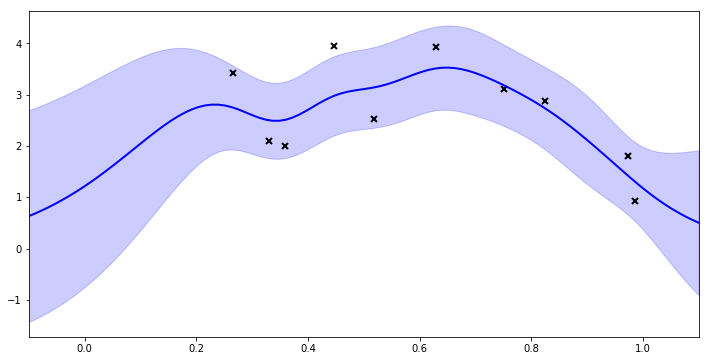

In [53]:
m.compile()
plot_model_predic_f(m)

### Cleaning

* Just painful

In [54]:
print("GPR parameters: {tensors}".format(tensors=list(m.trainable_tensors)))

GPR parameters: [<tf.Variable 'GPR/likelihood/variance/variable:0' shape=() dtype=float64_ref>, <tf.Variable 'GPR/kern/lengthscales/variable:0' shape=() dtype=float64_ref>, <tf.Variable 'GPR/kern/variance/variable:0' shape=() dtype=float64_ref>]


In [55]:
lengthscales_tensor_name = m.kern.lengthscales.transformed_tensor.name

m.clear()
print("GPR parameters: {tensors}".format(tensors=list(m.trainable_tensors)))
print("GPR is built: {built}".format(built=m.is_built_coherence()))

GPR parameters: [None, None, None]
GPR is built: Build.NO


### Cleaning. _What if we re-compile it?_

In [56]:
print("GPR is built: {built}".format(built=m.is_built_coherence()))

GPR is built: Build.NO


In [57]:
m.compile()

print("Lengthscale tensor name before: {name}".format(name=lengthscales_tensor_name))
print("Lengthscale tensor name after: {name}".format(name=m.kern.lengthscales.transformed_tensor.name))

Lengthscale tensor name before: GPR/kern/lengthscales/Identity:0
Lengthscale tensor name after: GPR_1/kern/lengthscales/Identity:0


# <center><b>What's next?</b></center>

* HMC works.

* GPflow optimizer interface.

* Minibatch via queuing.

* Compact project layout.

### Optimizer Interface

In [58]:
class Optimizer:
    def __init__(self, model):
        self._model = model

    @abc.abstractmethod
    def minimize(self, *args, **kwargs):
        raise NotImplementedError()

class ScipyOptimizer(Optimizer):
    def minimize(self, *args, **kwargs):
        pass

class TensorFlowOptimizer(Optimizer):
    def minimize(self, *args, **kwargs):
        pass

### Compact project layout.

```bash
gpflow
├── bases
│   └── ...
├── ekernels
│   └── ...
├── kernels
│   └── ...
├── models
│   └── ...
├── params
│   └── ...
├── training
│   └── ...
└── ...
```

# <center><b>Questions ?!</b></center>

![img](img/gpflow-logo.png)